In [1]:
import os
os.chdir('..')

import networkx as nx
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn.functional as F
import numpy as np
import scipy.sparse
import matplotlib.pyplot as plt

import persim # see persim.scikit-tda.org
from ripser import ripser # see ripser.scikit-tda.org

In [2]:
# Global-like variable definitions.
model_name = 'fc1'
dataset_name = 'mnist'
data_location = '../data' # location of training data (MNIST, FashionMNIST, CIFAR, etc.)
msk_pct = 90 # prune percentage for LT network
model_loc0 = 'saves/{}/{}/0_model_lt.pth.tar'.format(model_name, dataset_name) # location of saved, un-pruned model 
model_loc1 = 'saves/{}/{}/1_model_lt.pth.tar'.format(model_name, dataset_name) # location of saved, pruned model (after 1 prune iteration)

## Unpruned Model Homology

In [3]:
# load the model.
model = torch.load(model_loc0)

In [4]:
# access model params and add to list `params`. We are ignoring bias weights for now.
params = []
for name, param in model.named_parameters():
    if 'weight' in name:
        pnum = param.data.cpu().numpy()
        print('Parameter Shape: ', pnum.shape)
        params.append(pnum)

Parameter Shape:  (300, 784)
Parameter Shape:  (100, 300)
Parameter Shape:  (10, 100)


In [5]:
# helper function for testing model, outputs accuracy
def test(model, test_loader, criterion):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.data.max(1, keepdim=True)[1]  # get the index of the max log-probability
            correct += pred.eq(target.data.view_as(pred)).sum().item()
        test_loss /= len(test_loader.dataset)
        accuracy = 100. * correct / len(test_loader.dataset)
    return accuracy


# primary function for translating NN to networkx graph. 
def to_directed_networkx(params, layer_names=None):
    '''primary function for translating FCNN to networkx graph. 
    Gives node a name corresponding to its layer and location in 
    parameter matrix. Weights edges to match notion of "distance"
    matrix for nodes. 
    
    params (list): list of FC weight matrices in numpy format.
    layer_names (optional): list of layer names to be associated to each node
    (defaults to integer layer number).
    
    returns: networkx DiGraph.
    '''
    if layer_names is None:
        layer_names = [i for i in range(len(params))]
    G = nx.DiGraph()
    for i in range(len(params)):
        layer_name = layer_names[i]
        p = scipy.sparse.coo_matrix(params[i].T)
        for i,j,v in zip(p.row, p.col, p.data):
            if v != 0:
                G.add_edge(str(layer_name)+'_'+str(i),str(layer_name+1)+'_'+str(j),weight=np.abs(1/1+v))
    return G

In [6]:
# Test to make sure model works.
transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))])
testdataset = datasets.MNIST(data_location, train=False, transform=transform)
test_loader = torch.utils.data.DataLoader(testdataset, batch_size=32, shuffle=False, num_workers=0,drop_last=True)
criterion = torch.nn.CrossEntropyLoss()
print('Accuracy: {}'.format(test(model, test_loader, criterion)))

Accuracy: 97.09


In [7]:
# compute networkx representation of NN.
G = to_directed_networkx(params)

In [8]:
# sanity check on model parameters
en = 784+300+100+10 # expected number of nodes given the architecture
ee = 300*784+100*300+10*100 # expected number of edges given the architecture
nn = G.number_of_nodes() # number of nodes in our computed networkx representation
ne = G.number_of_edges() # number of edges in our computed networkx representation

print('Expected Nodes: {} | Expected Edges: {}'.format(en,ee))
print('Number of Nodes: {}, {:.2f}% | Number of Edges: {}, {:.2f}%'.format(nn, nn/en*100,ne, ne/ee*100))

Expected Nodes: 1194 | Expected Edges: 266200
Number of Nodes: 1194, 100.00% | Number of Edges: 266200, 100.00%


In [9]:
# compute rips persistent homology (up to 1st dimension) over entire network 
# using (sparse) adjacency matrix as distance matrix.
rips = ripser(nx.to_scipy_sparse_matrix(G), distance_matrix=True, maxdim=1)
rips

{'dgms': [array([[0.        , 0.98248565],
         [0.        , 0.98853326],
         [0.        , 0.98909342],
         ...,
         [0.        ,        inf],
         [0.        ,        inf],
         [0.        ,        inf]]),
  array([[1.58155715,        inf],
         [1.57476449,        inf],
         [1.54409647,        inf],
         ...,
         [0.99587959,        inf],
         [0.99578464,        inf],
         [0.99575984,        inf]])],
 'cocycles': [[], []],
 'num_edges': 31300,
 'dperm2all': <1194x1194 sparse matrix of type '<class 'numpy.float64'>'
 	with 266200 stored elements in Compressed Sparse Row format>,
 'idx_perm': array([   0,    1,    2, ..., 1191, 1192, 1193]),
 'r_cover': 0.0}

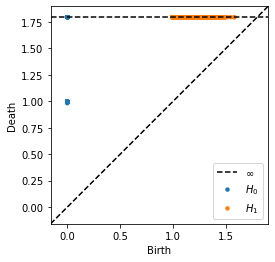

In [10]:
# plot persistence diagram in dimensions 0 and 1 (on same axes).
# points at infinity (homology groups) are plotted on the dotted 
# line which represents the point \infty.
persim.plot_diagrams(rips['dgms'])

## Pruned LT Homology

In [11]:
# load the LT model.
model_lt = torch.load(model_loc1)

In [12]:
# access model params and add to list `params`. We are ignoring bias weights for now.
params_lt = []
for name, param in model_lt.named_parameters():
    if 'weight' in name:
        pnum = param.data.cpu().numpy()
        print('Parameter Shape: ', pnum.shape)
        params_lt.append(pnum)

Parameter Shape:  (300, 784)
Parameter Shape:  (100, 300)
Parameter Shape:  (10, 100)


In [13]:
# test this model's accuracy.
print('Accuracy: {}'.format(test(model_lt, test_loader, criterion)))

Accuracy: 96.65


In [14]:
# compute networkx representation of LT NN.
G_lt = to_directed_networkx(params_lt)

In [15]:
# sanity check on model parameters, note decreased number of edges (and some nodes). 
nn = G_lt.number_of_nodes()
ne = G_lt.number_of_edges()
print('Expected Nodes: {} | Expected Edges: {}'.format(en,ee))
print('Number of Nodes: {}, {:.2f}% | Number of Edges: {}, {:.2f}%'.format(nn, nn/en*100,ne, ne/ee*100))

Expected Nodes: 1194 | Expected Edges: 266200
Number of Nodes: 1164, 97.49% | Number of Edges: 26620, 10.00%


In [16]:
# compute rips persistent homology (up to 1st dimension) over entire network 
# using (sparse) adjacency matrix as distance matrix.
rips_lt = ripser(nx.to_scipy_sparse_matrix(G_lt), distance_matrix=True, maxdim=1)
rips_lt

{'dgms': [array([[0.        , 0.99051774],
         [0.        , 0.9920485 ],
         [0.        , 0.9927153 ],
         ...,
         [0.        ,        inf],
         [0.        ,        inf],
         [0.        ,        inf]]),
  array([[2.33915043,        inf],
         [2.08174372,        inf],
         [2.07072401,        inf],
         ...,
         [1.        ,        inf],
         [1.        ,        inf],
         [1.        ,        inf]])],
 'cocycles': [[], []],
 'num_edges': 3373,
 'dperm2all': <1164x1164 sparse matrix of type '<class 'numpy.float64'>'
 	with 26620 stored elements in Compressed Sparse Row format>,
 'idx_perm': array([   0,    1,    2, ..., 1161, 1162, 1163]),
 'r_cover': 0.0}

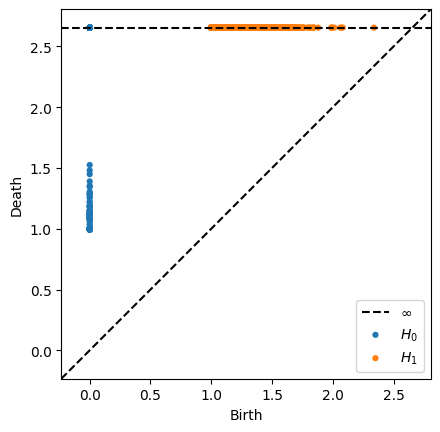

In [17]:
# plot persistence diagram in dimensions 0 and 1 (on same axes).
# points at infinity (homology groups) are plotted on the dotted 
# line which represents the point \infty.
persim.plot_diagrams(rips_lt['dgms'])

## Compare Networks

/home/schraterlab/gebhart/projects/LTH-Topology/env/lib/python3.6/site-packages/persim/bottleneck.py:55: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  "ignoring those points"
/home/schraterlab/gebhart/projects/LTH-Topology/env/lib/python3.6/site-packages/persim/bottleneck.py:65: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  "ignoring those points"


Bottleneck Distance: 0.5246462821960449


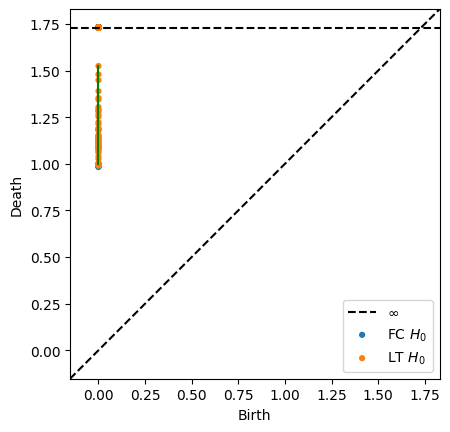

In [18]:
# compute the bottleneck distance between networks and plot the implicit matching. 
# bottleneck distance is defined as the distance between the farthest-apart matched points. 
# NOTE: the persim package ignores points at infinity, so this calculation still returns 
# a bounded result. Technically, the bottleneck distance between the two networks is \infty. 
distance_bottleneck, (matching, D) = persim.bottleneck(rips['dgms'][0], rips_lt['dgms'][0], matching=True)
persim.bottleneck_matching(rips['dgms'][0], rips_lt['dgms'][0], matching, D, labels=['FC $H_0$', 'LT $H_0$'])
print('Bottleneck Distance: {}'.format(distance_bottleneck))